# TF model v4.0
HS04 model incorporating non-stationary environment

# Parameters block (for papermill)

In [1]:
code_name = "_boo"
batch_name = None
# tf_root = "/home/jupyter/triangle_model"
tf_root = "/home/jal21012/triangle_model"

# Model configs
ort_units = 119
pho_units = 250
sem_units = 2446
hidden_os_units = 500
hidden_op_units = 100
hidden_ps_units = 500
hidden_sp_units = 500
pho_cleanup_units = 50
sem_cleanup_units = 50
pho_noise_level = 0.
sem_noise_level = 0.
activation = "sigmoid"

tau = 1 / 3
max_unit_time = 4.0
output_ticks = 13
inject_error_ticks = 11

# Training configs
learning_rate = 0.005
zero_error_radius = 0.1
save_freq = 100

# Environment configs
wf_compression = "log"
wf_clip_low = 0
wf_clip_high = 999_999_999

# task_names = ("pho_sem", "sem_pho", "pho_pho", "sem_sem", "ort_pho", "ort_sem", "triangle")
task_names = ("pho_sem", "sem_pho", "pho_pho", "sem_sem", "triangle")
tasks_ps_oral = (0.4, 0.4, 0.1, 0.1, 0.0)
tasks_ps_reading = (0.2, 0.2, 0.05, 0.05, 0.5)

total_sample = 10_000_000
batch_size = 100
rng_seed = 2021
which_gpu = 0

# Allocate GPU resources

In [2]:
import meta
meta.split_gpu(which_gpu=which_gpu)

In [3]:
import os
from tqdm import tqdm
from time import sleep
import meta, data_wrangling, metrics, modeling, benchmark_hs04
import environment as env
import tensorflow as tf

In [4]:
cfg = meta.Config.from_global(**globals())
# cfg = meta.Config.from_json(os.path.join(tf_root, "models", code_name, "model_config.json"))

UUID not found, regenerating.
Saved config json to /home/jal21012/triangle_model/models/_boo/model_config.json


# Build model and all supporting components

In [5]:
tf.random.set_seed(cfg.rng_seed)
data = data_wrangling.MyData()

# Architechture
model = modeling.MyModel(cfg)
model.build()

# Non-stationary Environment
# TODO: Maybe add support for universal constructor in Experiment 
experience = env.Experience.non_stationary_from_config(cfg.environment_config)
sampler = env.Sampler(cfg, data, experience)
batch_generator = sampler.generator()


## Plots to visualize environment

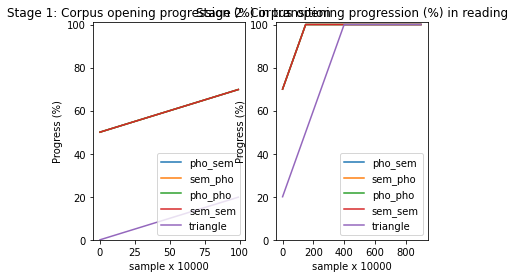

In [6]:
experience.plot_corpus()

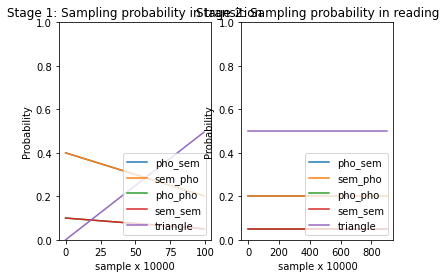

In [7]:
experience.plot_task_probability()

## Load pretrained model

In [ ]:
# weight_file = os.path.join("models", "Perfect_pretrain", "weights", "ep3000") 
# model.load_weights(weight_file)

## Core training modules

In [ ]:
# Since each sub-task has its own states, it must be trained with separate optimizer and losses,
# instead of sharing the same optimizer instance (https://github.com/tensorflow/tensorflow/issues/27120)
optimizers = {}
loss_fns = {}
train_losses = {}  # Mean loss (only for TensorBoard)
train_metrics = {}

# Task specific accuracy
## Caution PhoAccuracy is stateful (only taking last batch value in an epoch)
## Otherwise, all Stateless metrics are the average of all batches within an epoch

acc = {"pho": metrics.PhoAccuracy, "sem": metrics.StatelessRightSideAccuracy}
sse = metrics.StatelessSumSquaredError

for task in cfg.task_names:
    # optimizers[task] = tf.keras.optimizers.SGD(learning_rate=cfg.learning_rate)
    optimizers[task] = tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate)
    if cfg.zero_error_radius is not None:
        loss_fns[task] = metrics.CustomBCE(radius=cfg.zero_error_radius)
    else:
        loss_fns[task] = tf.keras.losses.BinaryCrossentropy()

    train_losses[task] = tf.keras.metrics.Mean(
        f"train_loss_{task}", dtype=tf.float32
    )  # for tensorboard only

    task_output = modeling.IN_OUT[task][1]

    if type(task_output) is list:
        train_metrics[task] = {}

        for out in task_output:
            train_metrics[task][out] = [
                acc[out](f"{task}_{out}_acc"),
                sse(f"{task}_{out}_sse"),
            ]
    else:
        train_metrics[task] = [acc[task_output](f"{task}_acc"), sse(f"{task}_sse")]

# Trainstep

In [ ]:
def get_train_step(task):
    input_name, output_name = modeling.IN_OUT[task]

    if task == "triangle":

        @tf.function()
        def train_step(
            x, y, model, task, loss_fn, optimizer, train_metrics, train_losses
        ):
            """Train a batch, log loss and metrics (last time step only)"""

            train_weights_name = [x + ":0" for x in modeling.WEIGHTS_AND_BIASES[task]]
            train_weights = [x for x in model.weights if x.name in train_weights_name]

            # TF Automatic differentiation
            with tf.GradientTape() as tape:
                y_pred = model(x, training=True)
                # training flag can be access within model by K.in_train_phase()
                # it can change the behavior in model() (e.g., turn on/off noise)

                loss_value_pho = loss_fn(y["pho"], y_pred["pho"])
                loss_value_sem = loss_fn(y["sem"], y_pred["sem"])
                loss_value = loss_value_pho + loss_value_sem

            grads = tape.gradient(loss_value, train_weights)

            # Weight update
            optimizer.apply_gradients(zip(grads, train_weights))

            # Calculate mean loss and metrics for tensorboard
            # Metrics update (Only last time step)
            # for y_name, metrics in train_metrics.items():
            #     if y_name == "pho":
            #         # y[0] is pho, y[0][-1] is last time step in pho
            #         [
            #             m.update_state(
            #                 tf.cast(y["pho"][-1], tf.float32), y_pred["pho"][-1]
            #             )
            #             for m in metrics
            #         ]
            #     else:
            #         # y[1] is sem, y[0][-1] is last time step in sem
            #         [
            #             m.update_state(
            #                 tf.cast(y["sem"][-1], tf.float32), y_pred["sem"][-1]
            #             )
            #             for m in metrics
            #         ]

            # Mean loss
            train_losses.update_state(loss_value)

    else:  # Single output tasks

        @tf.function()
        def train_step(
            x, y, model, task, loss_fn, optimizer, train_metrics, train_losses
        ):
            train_weights_name = [x + ":0" for x in modeling.WEIGHTS_AND_BIASES[task]]
            train_weights = [x for x in model.weights if x.name in train_weights_name]

            with tf.GradientTape() as tape:
                y_pred = model(x, training=True)
                loss_value = loss_fn(y, y_pred[output_name])

            grads = tape.gradient(loss_value, train_weights)
            optimizer.apply_gradients(zip(grads, train_weights))

            # [
            #     m.update_state(tf.cast(y[-1], tf.float32), y_pred[output_name][-1])
            #     for m in train_metrics
            # ]
            train_losses.update_state(loss_value)

    return train_step


train_steps = {task: get_train_step(task) for task in cfg.task_names}
# train_steps = {task: modeling.get_train_step(task) for task in cfg.tasks}

## Tensorboard module

In [ ]:
# def write_scalar_to_tensorboard(task, step):
#     """Write metrics and loss to tensorboard"""
#     loss = train_losses[task]
#     tf.summary.scalar(loss.name, loss.result(), step=step)

#     maybe_metrics = train_metrics[task]
#     if task == "triangle":
#         [
#             tf.summary.scalar(m.name, m.result(), step=step)
#             for metrics in maybe_metrics.values()
#             for m in metrics
#         ]
#     else:
#         [tf.summary.scalar(m.name, m.result(), step=step) for m in maybe_metrics]


def write_weight_histogram_to_tensorboard(step):
    """Weight histogram"""
    [tf.summary.histogram(f"{x.name}",   x, step=step) for x in model.weights]


# def reset_metrics(task):
#     maybe_metrics = train_metrics[task]
#     if task == "triangle":
#         [m.reset_states() for metrics in maybe_metrics.values() for m in metrics]
#     else:
#         [m.reset_states() for m in maybe_metrics]

# TensorBoard writer
train_summary_writer = tf.summary.create_file_writer(
    os.path.join(cfg.tensorboard_folder, "train")
)

## Checkpoint module

In [ ]:
epoch = tf.Variable(0, name='epoch')

ckpt = tf.train.Checkpoint(
    model=model, 
    optimizers=optimizers, 
    epoch=epoch
    )
    
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    cfg.weight_folder, 
    max_to_keep=None,  # Keep all checkpoints
    checkpoint_name="epoch",
)

# Train model

In [ ]:
# Restore from checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

In [ ]:
progress_bar = tqdm(total=cfg.total_number_of_epoch, desc="Training")
progress_bar.update(epoch.numpy())

while epoch.numpy() < cfg.total_number_of_epoch:

    # Train an epoch
    for step in range(cfg.steps_per_epoch):
        # Draw task, create batch
        task, exposed_words_idx, x_batch_train, y_batch_train = next(batch_generator)

        # task switching must be done outside train_step function (will crash otherwise)
        model.set_active_task(task)

        # Run a train step
        train_steps[task](
            x_batch_train,
            y_batch_train,
            model,
            task,
            loss_fns[task],
            optimizers[task],
            train_metrics[task],
            train_losses[task],
        )

    # Post epoch Ops
    progress_bar.update(1)
    epoch.assign_add(1)
    
    with train_summary_writer.as_default():
        ## Write log to tensorboard (Once per epoch)
        # [write_scalar_to_tensorboard(task, step=epoch) for task in cfg.tasks]
        write_weight_histogram_to_tensorboard(step=epoch.numpy())

    #     ## Reset metric and loss
        [train_losses[x].reset_states() for x in cfg.task_names]
    #     [reset_metrics(x) for x in cfg.tasks]

    # In training loop testset eval
    # Kind of fast, but hard to integrate and customize... maybe use offline eval again.
    # [strain(task, step=epoch) for task in strain.tasks]
    # [grain(task, step=epoch) for task in grain.tasks]

    ## Save weights every save_freq epochs
    if epoch.numpy() % cfg.save_freq == 0:
        f=ckpt_manager.save(epoch)

# Run benchmark

In [ ]:
# Run usual evals
if cfg.batch_name is not None:
    benchmark_hs04.main(f"{cfg.batch_name}/{cfg.code_name}")
else:
    benchmark_hs04.main(cfg.code_name)

In [ ]:
# !gsutil -m rsync -d -r models/{code_name} gs://tf_mirror/{code_name}
# sleep(30)
# !sudo shutdown -P +0